In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
torch.manual_seed(42)
import matplotlib.pyplot as plt
from PIL import Image
import skimage
np.random.seed(42)
torch.manual_seed(42)

In [2]:
import cv2

In [3]:
class relu_mlp(nn.Module):
  def __init__(self, neurons, h_layers):
    super(relu_mlp, self).__init__()
    self.neurons = neurons
    self.h_layers = h_layers

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(2,neurons))
    for i in range (h_layers-1):
      self.layers.append(nn.Linear(neurons,neurons))
    self.layers.append(nn.Linear(neurons, 1))
  
  def forward (self,x):
    for layer in self.layers[:-1]:
      x = F.relu(layer(x))
    x = self.layers[-1](x)
    return x

In [4]:
class siren_mlp(nn.Module):
  def __init__(self, neurons, h_layers, omega):
    super(siren_mlp, self).__init__()
    self.neurons = neurons
    self.h_layers = h_layers
    self.omega = omega

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(2, neurons))
    for i in range(h_layers-1):
      self.layers.append(nn.Linear(neurons, neurons))
    self.layers.append(nn.Linear(neurons,1))

    nn.init.uniform_(self.layers[0].weight,-1/2,1/2)
    for layer in self.layers[1:]:
      nn.init.uniform_(layer.weight,-np.sqrt(6/neurons)/omega, np.sqrt(6/neurons)/omega)
  
  def forward (self, x):
    for layer in self.layers[:-1]:
      x = torch.sin(layer(x))
    x = self.layers[-1](x)
    return x

In [5]:
def coordinates (n):
  # Create an empty list to store the tuples
  tuples = []

  # Iterate over all x and y values from 0 to 512
  for x in range(n):
      for y in range(n):
          # Append the current tuple to the list
          tuples.append([x, y])

  # Convert the list to a NumPy array if desired
  tuples_array = np.array(tuples)
  return tuples_array

In [6]:
img = Image.fromarray(skimage.data.camera())        

In [ ]:
img = img.resize((256,256))

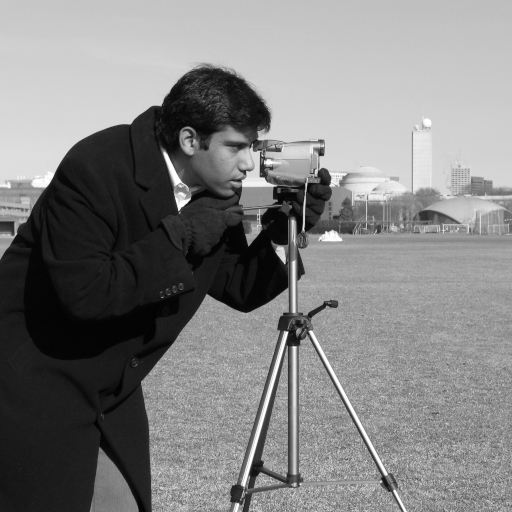

In [7]:
img

In [8]:
image_array = np.asarray(img)
image_array_rescaled = (image_array-127.5)/127.5

In [9]:
import cv2

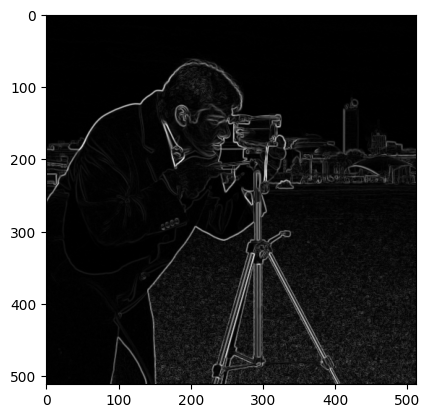

In [10]:
sobel_x = cv2.Sobel(image_array, cv2.CV_64F, 1, 0, ksize=3)

# Apply the Sobel filter in the y direction
sobel_y = cv2.Sobel(image_array, cv2.CV_64F, 0, 1, ksize=3)

# Compute the magnitude of the gradient
mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
plt.imshow(mag, cmap = "gray")

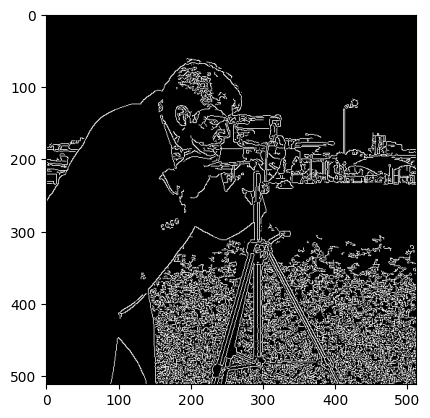

In [11]:
img_gradient = cv2.Canny(image_array.astype('uint8'),50,150)
plt.imshow(img_gradient, cmap = "gray")

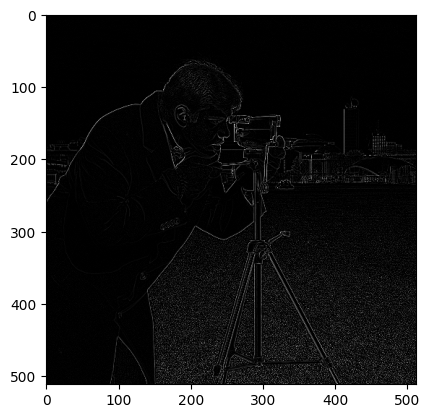

In [12]:
img_laplacian = cv2.Laplacian(image_array.astype('uint8'),50,150)
plt.imshow(img_laplacian, cmap = "gray")

In [13]:
from tqdm import tqdm

In [14]:
device = 'cuda'

In [17]:
img.size

(512, 512)

In [15]:
torch.cuda.is_available()

True

In [60]:
relu_model = relu_mlp(256,5).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(relu_model.parameters(), lr=0.0001)

In [61]:
X = coordinates(512)
y = image_array_rescaled.reshape(-1)

In [62]:
relu_psnr = []

In [64]:
num_epochs = 15000
for e in tqdm(range(num_epochs)):
  y_pred_train = relu_model(torch.from_numpy(X.astype('float32')).to(device)).squeeze()
  loss = criterion(y_pred_train, torch.from_numpy(y.astype('float32')).to(device)) # loss is a tensor which stores the current value of train loss
  relu_psnr.append(20 * np.log10(1.0 / np.sqrt(loss.item())))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 100 == 0:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss
  if e == num_epochs-1:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss

  0%|          | 1/15000 [00:00<47:34,  5.25it/s]

Epoch [0/15000], Loss: 5.3018


  1%|          | 103/15000 [00:13<31:40,  7.84it/s]

Epoch [100/15000], Loss: 0.2026


  1%|▏         | 203/15000 [00:26<32:00,  7.70it/s]

Epoch [200/15000], Loss: 0.1976


  2%|▏         | 303/15000 [00:40<31:59,  7.66it/s]

Epoch [300/15000], Loss: 0.1918


  3%|▎         | 403/15000 [00:54<32:33,  7.47it/s]

Epoch [400/15000], Loss: 0.1931


  3%|▎         | 503/15000 [01:08<32:40,  7.40it/s]

Epoch [500/15000], Loss: 0.1813


  4%|▍         | 603/15000 [01:22<32:26,  7.40it/s]

Epoch [600/15000], Loss: 0.1890


  5%|▍         | 703/15000 [01:36<31:56,  7.46it/s]

Epoch [700/15000], Loss: 0.1979


  5%|▌         | 803/15000 [01:50<31:17,  7.56it/s]

Epoch [800/15000], Loss: 0.1772


  6%|▌         | 903/15000 [02:04<31:02,  7.57it/s]

Epoch [900/15000], Loss: 0.1641


  7%|▋         | 1003/15000 [02:18<30:53,  7.55it/s]

Epoch [1000/15000], Loss: 0.1778


  7%|▋         | 1103/15000 [02:32<30:41,  7.54it/s]

Epoch [1100/15000], Loss: 0.1509


  8%|▊         | 1203/15000 [02:46<30:57,  7.43it/s]

Epoch [1200/15000], Loss: 0.1736


  9%|▊         | 1303/15000 [02:59<30:33,  7.47it/s]

Epoch [1300/15000], Loss: 0.1554


  9%|▉         | 1403/15000 [03:13<30:30,  7.43it/s]

Epoch [1400/15000], Loss: 0.1644


 10%|█         | 1503/15000 [03:27<30:17,  7.43it/s]

Epoch [1500/15000], Loss: 0.1412


 11%|█         | 1603/15000 [03:41<29:57,  7.45it/s]

Epoch [1600/15000], Loss: 0.1511


 11%|█▏        | 1703/15000 [03:55<29:27,  7.52it/s]

Epoch [1700/15000], Loss: 0.1917


 12%|█▏        | 1803/15000 [04:09<29:08,  7.55it/s]

Epoch [1800/15000], Loss: 0.1296


 13%|█▎        | 1903/15000 [04:23<29:17,  7.45it/s]

Epoch [1900/15000], Loss: 0.1218


 13%|█▎        | 2003/15000 [04:37<28:57,  7.48it/s]

Epoch [2000/15000], Loss: 0.1186


 14%|█▍        | 2103/15000 [04:51<28:55,  7.43it/s]

Epoch [2100/15000], Loss: 0.1175


 15%|█▍        | 2203/15000 [05:05<28:44,  7.42it/s]

Epoch [2200/15000], Loss: 0.1124


 15%|█▌        | 2303/15000 [05:19<28:24,  7.45it/s]

Epoch [2300/15000], Loss: 0.1058


 16%|█▌        | 2403/15000 [05:33<28:14,  7.44it/s]

Epoch [2400/15000], Loss: 0.1087


 17%|█▋        | 2503/15000 [05:47<28:02,  7.43it/s]

Epoch [2500/15000], Loss: 0.1114


 17%|█▋        | 2603/15000 [06:01<27:49,  7.42it/s]

Epoch [2600/15000], Loss: 0.1013


 18%|█▊        | 2703/15000 [06:15<27:15,  7.52it/s]

Epoch [2700/15000], Loss: 0.1024


 19%|█▊        | 2803/15000 [06:29<26:55,  7.55it/s]

Epoch [2800/15000], Loss: 0.1024


 19%|█▉        | 2903/15000 [06:43<26:54,  7.49it/s]

Epoch [2900/15000], Loss: 0.0952


 20%|██        | 3003/15000 [06:57<26:45,  7.47it/s]

Epoch [3000/15000], Loss: 0.0874


 21%|██        | 3103/15000 [07:11<26:29,  7.48it/s]

Epoch [3100/15000], Loss: 0.0861


 21%|██▏       | 3203/15000 [07:25<26:27,  7.43it/s]

Epoch [3200/15000], Loss: 0.0850


 22%|██▏       | 3303/15000 [07:39<26:06,  7.47it/s]

Epoch [3300/15000], Loss: 0.0863


 23%|██▎       | 3403/15000 [07:53<25:38,  7.54it/s]

Epoch [3400/15000], Loss: 0.0831


 23%|██▎       | 3503/15000 [08:07<25:41,  7.46it/s]

Epoch [3500/15000], Loss: 0.0844


 24%|██▍       | 3603/15000 [08:21<25:24,  7.48it/s]

Epoch [3600/15000], Loss: 0.0867


 25%|██▍       | 3703/15000 [08:35<25:02,  7.52it/s]

Epoch [3700/15000], Loss: 0.0849


 25%|██▌       | 3803/15000 [08:49<24:59,  7.46it/s]

Epoch [3800/15000], Loss: 0.0922


 26%|██▌       | 3903/15000 [09:03<25:02,  7.39it/s]

Epoch [3900/15000], Loss: 0.0820


 27%|██▋       | 4003/15000 [09:17<24:39,  7.43it/s]

Epoch [4000/15000], Loss: 0.0841


 27%|██▋       | 4103/15000 [09:31<24:16,  7.48it/s]

Epoch [4100/15000], Loss: 0.0889


 28%|██▊       | 4203/15000 [09:45<24:17,  7.41it/s]

Epoch [4200/15000], Loss: 0.1001


 29%|██▊       | 4303/15000 [09:59<24:00,  7.42it/s]

Epoch [4300/15000], Loss: 0.0869


 29%|██▉       | 4403/15000 [10:13<23:45,  7.43it/s]

Epoch [4400/15000], Loss: 0.0872


 30%|███       | 4503/15000 [10:27<23:14,  7.53it/s]

Epoch [4500/15000], Loss: 0.0790


 31%|███       | 4603/15000 [10:40<23:20,  7.43it/s]

Epoch [4600/15000], Loss: 0.0997


 31%|███▏      | 4703/15000 [10:54<22:47,  7.53it/s]

Epoch [4700/15000], Loss: 0.0772


 32%|███▏      | 4803/15000 [11:08<22:53,  7.43it/s]

Epoch [4800/15000], Loss: 0.0754


 33%|███▎      | 4903/15000 [11:22<22:36,  7.44it/s]

Epoch [4900/15000], Loss: 0.0873


 33%|███▎      | 5003/15000 [11:36<22:25,  7.43it/s]

Epoch [5000/15000], Loss: 0.0770


 34%|███▍      | 5103/15000 [11:50<22:08,  7.45it/s]

Epoch [5100/15000], Loss: 0.0807


 35%|███▍      | 5203/15000 [12:04<21:40,  7.53it/s]

Epoch [5200/15000], Loss: 0.0801


 35%|███▌      | 5303/15000 [12:18<21:43,  7.44it/s]

Epoch [5300/15000], Loss: 0.1188


 36%|███▌      | 5403/15000 [12:32<21:16,  7.52it/s]

Epoch [5400/15000], Loss: 0.0788


 37%|███▋      | 5503/15000 [12:46<21:03,  7.52it/s]

Epoch [5500/15000], Loss: 0.0775


 37%|███▋      | 5603/15000 [13:00<21:02,  7.44it/s]

Epoch [5600/15000], Loss: 0.0845


 38%|███▊      | 5703/15000 [13:14<20:31,  7.55it/s]

Epoch [5700/15000], Loss: 0.0817


 39%|███▊      | 5803/15000 [13:28<20:39,  7.42it/s]

Epoch [5800/15000], Loss: 0.0816


 39%|███▉      | 5903/15000 [13:42<20:11,  7.51it/s]

Epoch [5900/15000], Loss: 0.0870


 40%|████      | 6003/15000 [13:56<20:08,  7.44it/s]

Epoch [6000/15000], Loss: 0.0768


 41%|████      | 6103/15000 [14:10<19:55,  7.44it/s]

Epoch [6100/15000], Loss: 0.0701


 41%|████▏     | 6203/15000 [14:24<19:37,  7.47it/s]

Epoch [6200/15000], Loss: 0.1081


 42%|████▏     | 6303/15000 [14:38<19:15,  7.53it/s]

Epoch [6300/15000], Loss: 0.0795


 43%|████▎     | 6403/15000 [14:52<19:17,  7.43it/s]

Epoch [6400/15000], Loss: 0.1014


 43%|████▎     | 6503/15000 [15:06<19:03,  7.43it/s]

Epoch [6500/15000], Loss: 0.0745


 44%|████▍     | 6603/15000 [15:20<18:50,  7.43it/s]

Epoch [6600/15000], Loss: 0.0761


 45%|████▍     | 6703/15000 [15:34<18:15,  7.57it/s]

Epoch [6700/15000], Loss: 0.0843


 45%|████▌     | 6803/15000 [15:47<18:06,  7.54it/s]

Epoch [6800/15000], Loss: 0.0706


 46%|████▌     | 6903/15000 [16:01<17:57,  7.52it/s]

Epoch [6900/15000], Loss: 0.0696


 47%|████▋     | 7003/15000 [16:15<17:35,  7.57it/s]

Epoch [7000/15000], Loss: 0.0712


 47%|████▋     | 7103/15000 [16:29<17:21,  7.58it/s]

Epoch [7100/15000], Loss: 0.0717


 48%|████▊     | 7203/15000 [16:43<17:11,  7.56it/s]

Epoch [7200/15000], Loss: 0.0708


 49%|████▊     | 7303/15000 [16:56<16:51,  7.61it/s]

Epoch [7300/15000], Loss: 0.0837


 49%|████▉     | 7403/15000 [17:10<16:35,  7.63it/s]

Epoch [7400/15000], Loss: 0.0949


 50%|█████     | 7503/15000 [17:24<16:33,  7.55it/s]

Epoch [7500/15000], Loss: 0.0688


 51%|█████     | 7603/15000 [17:38<16:16,  7.58it/s]

Epoch [7600/15000], Loss: 0.0753


 51%|█████▏    | 7703/15000 [17:51<15:59,  7.61it/s]

Epoch [7700/15000], Loss: 0.0670


 52%|█████▏    | 7803/15000 [18:05<15:44,  7.62it/s]

Epoch [7800/15000], Loss: 0.0699


 53%|█████▎    | 7903/15000 [18:19<15:26,  7.66it/s]

Epoch [7900/15000], Loss: 0.0846


 53%|█████▎    | 8003/15000 [18:32<15:22,  7.58it/s]

Epoch [8000/15000], Loss: 0.0618


 54%|█████▍    | 8103/15000 [18:46<15:07,  7.60it/s]

Epoch [8100/15000], Loss: 0.0755


 55%|█████▍    | 8203/15000 [19:00<14:54,  7.60it/s]

Epoch [8200/15000], Loss: 0.0689


 55%|█████▌    | 8303/15000 [19:14<14:43,  7.58it/s]

Epoch [8300/15000], Loss: 0.0611


 56%|█████▌    | 8403/15000 [19:27<14:24,  7.63it/s]

Epoch [8400/15000], Loss: 0.0579


 57%|█████▋    | 8503/15000 [19:41<14:19,  7.55it/s]

Epoch [8500/15000], Loss: 0.0702


 57%|█████▋    | 8603/15000 [19:55<13:57,  7.63it/s]

Epoch [8600/15000], Loss: 0.0563


 58%|█████▊    | 8703/15000 [20:08<13:47,  7.61it/s]

Epoch [8700/15000], Loss: 0.0562


 59%|█████▊    | 8803/15000 [20:22<13:36,  7.59it/s]

Epoch [8800/15000], Loss: 0.0641


 59%|█████▉    | 8903/15000 [20:36<13:20,  7.61it/s]

Epoch [8900/15000], Loss: 0.0547


 60%|██████    | 9003/15000 [20:50<13:09,  7.60it/s]

Epoch [9000/15000], Loss: 0.0652


 61%|██████    | 9103/15000 [21:03<13:01,  7.55it/s]

Epoch [9100/15000], Loss: 0.1240


 61%|██████▏   | 9203/15000 [21:17<12:44,  7.58it/s]

Epoch [9200/15000], Loss: 0.0574


 62%|██████▏   | 9303/15000 [21:31<12:31,  7.58it/s]

Epoch [9300/15000], Loss: 0.0559


 63%|██████▎   | 9403/15000 [21:44<12:19,  7.57it/s]

Epoch [9400/15000], Loss: 0.0795


 63%|██████▎   | 9503/15000 [21:58<12:06,  7.57it/s]

Epoch [9500/15000], Loss: 0.0597


 64%|██████▍   | 9603/15000 [22:12<11:55,  7.54it/s]

Epoch [9600/15000], Loss: 0.0575


 65%|██████▍   | 9703/15000 [22:25<11:37,  7.60it/s]

Epoch [9700/15000], Loss: 0.0596


 65%|██████▌   | 9803/15000 [22:39<11:23,  7.60it/s]

Epoch [9800/15000], Loss: 0.0644


 66%|██████▌   | 9903/15000 [22:53<11:10,  7.60it/s]

Epoch [9900/15000], Loss: 0.0640


 67%|██████▋   | 10003/15000 [23:06<10:55,  7.62it/s]

Epoch [10000/15000], Loss: 0.0703


 67%|██████▋   | 10103/15000 [23:20<10:43,  7.61it/s]

Epoch [10100/15000], Loss: 0.0588


 68%|██████▊   | 10203/15000 [23:34<10:31,  7.59it/s]

Epoch [10200/15000], Loss: 0.0559


 69%|██████▊   | 10303/15000 [23:48<10:16,  7.62it/s]

Epoch [10300/15000], Loss: 0.0532


 69%|██████▉   | 10403/15000 [24:01<09:59,  7.67it/s]

Epoch [10400/15000], Loss: 0.0557


 70%|███████   | 10503/15000 [24:15<09:54,  7.57it/s]

Epoch [10500/15000], Loss: 0.0550


 71%|███████   | 10603/15000 [24:29<09:37,  7.61it/s]

Epoch [10600/15000], Loss: 0.0486


 71%|███████▏  | 10703/15000 [24:42<09:23,  7.62it/s]

Epoch [10700/15000], Loss: 0.0484


 72%|███████▏  | 10803/15000 [24:56<09:10,  7.63it/s]

Epoch [10800/15000], Loss: 0.0531


 73%|███████▎  | 10903/15000 [25:10<08:57,  7.62it/s]

Epoch [10900/15000], Loss: 0.0602


 73%|███████▎  | 11003/15000 [25:23<08:47,  7.57it/s]

Epoch [11000/15000], Loss: 0.0521


 74%|███████▍  | 11103/15000 [25:37<08:35,  7.56it/s]

Epoch [11100/15000], Loss: 0.0499


 75%|███████▍  | 11203/15000 [25:51<08:19,  7.61it/s]

Epoch [11200/15000], Loss: 0.0999


 75%|███████▌  | 11303/15000 [26:04<08:07,  7.59it/s]

Epoch [11300/15000], Loss: 0.0694


 76%|███████▌  | 11403/15000 [26:18<07:48,  7.67it/s]

Epoch [11400/15000], Loss: 0.0621


 77%|███████▋  | 11503/15000 [26:32<07:37,  7.65it/s]

Epoch [11500/15000], Loss: 0.0626


 77%|███████▋  | 11603/15000 [26:45<07:23,  7.67it/s]

Epoch [11600/15000], Loss: 0.0542


 78%|███████▊  | 11703/15000 [26:59<07:12,  7.63it/s]

Epoch [11700/15000], Loss: 0.0529


 79%|███████▊  | 11803/15000 [27:13<07:01,  7.59it/s]

Epoch [11800/15000], Loss: 0.0632


 79%|███████▉  | 11903/15000 [27:26<06:44,  7.67it/s]

Epoch [11900/15000], Loss: 0.0570


 80%|████████  | 12003/15000 [27:40<06:32,  7.64it/s]

Epoch [12000/15000], Loss: 0.0512


 81%|████████  | 12103/15000 [27:54<06:21,  7.59it/s]

Epoch [12100/15000], Loss: 0.0637


 81%|████████▏ | 12203/15000 [28:07<06:11,  7.52it/s]

Epoch [12200/15000], Loss: 0.0506


 82%|████████▏ | 12303/15000 [28:21<05:57,  7.55it/s]

Epoch [12300/15000], Loss: 0.0574


 83%|████████▎ | 12403/15000 [28:35<05:41,  7.60it/s]

Epoch [12400/15000], Loss: 0.0489


 83%|████████▎ | 12503/15000 [28:48<05:27,  7.63it/s]

Epoch [12500/15000], Loss: 0.0565


 84%|████████▍ | 12603/15000 [29:02<05:12,  7.66it/s]

Epoch [12600/15000], Loss: 0.0633


 85%|████████▍ | 12703/15000 [29:16<05:00,  7.64it/s]

Epoch [12700/15000], Loss: 0.0488


 85%|████████▌ | 12803/15000 [29:29<04:49,  7.58it/s]

Epoch [12800/15000], Loss: 0.0461


 86%|████████▌ | 12903/15000 [29:43<04:36,  7.59it/s]

Epoch [12900/15000], Loss: 0.0470


 87%|████████▋ | 13003/15000 [29:57<04:20,  7.66it/s]

Epoch [13000/15000], Loss: 0.0454


 87%|████████▋ | 13103/15000 [30:10<04:10,  7.58it/s]

Epoch [13100/15000], Loss: 0.0459


 88%|████████▊ | 13203/15000 [30:24<03:56,  7.60it/s]

Epoch [13200/15000], Loss: 0.0496


 89%|████████▊ | 13303/15000 [30:38<03:41,  7.65it/s]

Epoch [13300/15000], Loss: 0.0586


 89%|████████▉ | 13403/15000 [30:51<03:28,  7.64it/s]

Epoch [13400/15000], Loss: 0.0559


 90%|█████████ | 13503/15000 [31:05<03:15,  7.65it/s]

Epoch [13500/15000], Loss: 0.0459


 91%|█████████ | 13603/15000 [31:19<03:02,  7.66it/s]

Epoch [13600/15000], Loss: 0.0463


 91%|█████████▏| 13703/15000 [31:32<02:50,  7.60it/s]

Epoch [13700/15000], Loss: 0.0613


 92%|█████████▏| 13803/15000 [31:46<02:36,  7.64it/s]

Epoch [13800/15000], Loss: 0.0461


 93%|█████████▎| 13903/15000 [32:00<02:24,  7.59it/s]

Epoch [13900/15000], Loss: 0.0483


 93%|█████████▎| 14003/15000 [32:13<02:10,  7.62it/s]

Epoch [14000/15000], Loss: 0.0439


 94%|█████████▍| 14103/15000 [32:27<01:57,  7.62it/s]

Epoch [14100/15000], Loss: 0.0431


 95%|█████████▍| 14203/15000 [32:41<01:45,  7.56it/s]

Epoch [14200/15000], Loss: 0.0539


 95%|█████████▌| 14303/15000 [32:54<01:32,  7.56it/s]

Epoch [14300/15000], Loss: 0.0423


 96%|█████████▌| 14403/15000 [33:08<01:17,  7.65it/s]

Epoch [14400/15000], Loss: 0.0791


 97%|█████████▋| 14503/15000 [33:22<01:05,  7.64it/s]

Epoch [14500/15000], Loss: 0.0433


 97%|█████████▋| 14603/15000 [33:35<00:51,  7.67it/s]

Epoch [14600/15000], Loss: 0.0587


 98%|█████████▊| 14703/15000 [33:49<00:39,  7.59it/s]

Epoch [14700/15000], Loss: 0.0424


 99%|█████████▊| 14803/15000 [34:03<00:25,  7.64it/s]

Epoch [14800/15000], Loss: 0.0505


 99%|█████████▉| 14903/15000 [34:16<00:12,  7.64it/s]

Epoch [14900/15000], Loss: 0.0672


100%|██████████| 15000/15000 [34:30<00:00,  7.25it/s]

Epoch [14999/15000], Loss: 0.0464


In [65]:
len(relu_psnr)

15000

In [66]:
y_preds = relu_model(torch.from_numpy(X.astype('float32')).to(device))

In [67]:
y_image_values = (y_preds.cpu().detach().numpy().reshape(512,512)*127.5)+127.5
y_image_values

array([[200.06792 , 200.26479 , 200.38266 , ..., 188.06085 , 188.08078 ,
        188.10062 ],
       [199.30751 , 199.42245 , 199.35384 , ..., 187.9854  , 188.00279 ,
        188.02037 ],
       [198.81741 , 199.4169  , 198.47276 , ..., 187.93304 , 187.94565 ,
        187.95857 ],
       ...,
       [ 20.82415 ,  20.808182,  20.761253, ..., 143.2993  , 143.15384 ,
        143.00835 ],
       [ 20.729889,  20.714157,  20.666801, ..., 143.48329 , 143.30505 ,
        143.15955 ],
       [ 20.63581 ,  20.619804,  20.572945, ..., 143.71065 , 143.49399 ,
        143.31047 ]], dtype=float32)

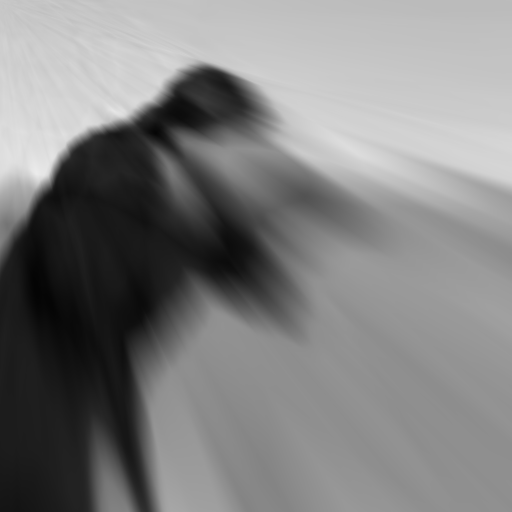

In [68]:
relu_img = Image.fromarray(y_image_values)
relu_img.show()

In [69]:
X_temp = torch.tensor(X.astype('float32'), requires_grad = True).to(device)
y_preds = relu_model(X_temp).to(device)

In [70]:
grad_ = torch.autograd.grad(y_preds, X_temp,grad_outputs = torch.ones_like(y_preds), create_graph=True)[0]

In [71]:
grad__ = torch.autograd.grad(y_preds, X_temp,grad_outputs = torch.ones_like(y_preds), create_graph=True, retain_graph = True)[0]

In [72]:
type(grad_), grad_.shape

(torch.Tensor, torch.Size([262144, 2]))

In [73]:
grad_array = grad_.cpu().detach().numpy()
grad_array

array([[ 0.0149342 , -0.07504304],
       [ 0.07527256,  0.0259804 ],
       [ 0.05524215, -0.01054927],
       ...,
       [ 0.00177926, -0.00169641],
       [ 0.00177926, -0.00169641],
       [ 0.00118686, -0.00114114]], dtype=float32)

In [74]:
grad_array.shape

(262144, 2)

In [75]:
grad_x = grad_array[:, 0].reshape(-1, 1)
grad_y = grad_array[:, 1].reshape(-1, 1)

In [76]:
grad_x = grad_x.reshape(512,512)
grad_y = grad_y.reshape(512,512)
grad_x = (grad_x*127.5) + 127.5
grad_y = (grad_y*127.5) + 127.5

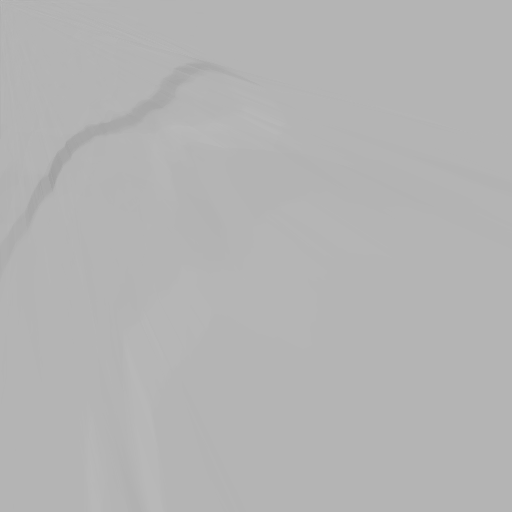

In [77]:
gradient_image_relu = np.sqrt(grad_x**2 + grad_y**2)
gradient_actual_relu = Image.fromarray(gradient_image_relu.astype('uint8'))
gradient_actual_relu

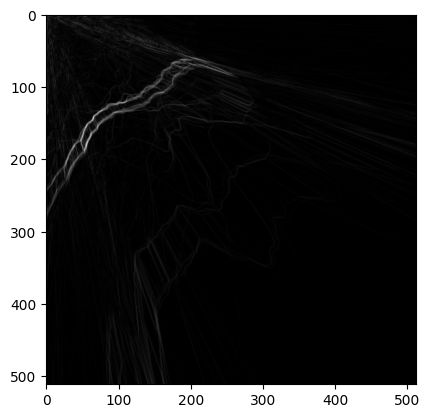

In [78]:
sobel_x = cv2.Sobel(gradient_image_relu, cv2.CV_64F, 1, 0, ksize=3)

# Apply the Sobel filter in the y direction
sobel_y = cv2.Sobel(gradient_image_relu, cv2.CV_64F, 0, 1, ksize=3)

# Compute the magnitude of the gradient
grad_relu = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
plt.imshow(grad_relu, cmap = "gray")

array([[220.63448, 173.9029 , 189.33618, ..., 180.22684, 180.22684,
        180.22684],
       [194.59306, 169.92296, 175.80316, ..., 180.23657, 180.40912,
        180.40912],
       [181.28276, 177.02325, 182.56775, ..., 180.38954, 180.38954,
        180.53941],
       ...,
       [180.56906, 180.63493, 180.48515, ..., 180.21501, 180.21107,
        180.2109 ],
       [180.56906, 180.63493, 180.63493, ..., 180.21501, 180.21501,
        180.21107],
       [180.56906, 180.63493, 180.63493, ..., 180.21365, 180.21501,
        180.21501]], dtype=float32)

In [79]:
laplace = torch.autograd.grad(torch.sum(grad_), X_temp)[0]

In [80]:
laplace

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0')

In [81]:
laplace.shape

torch.Size([262144, 2])

In [82]:
laplace_array = laplace.cpu().detach().numpy()
laplace_array

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [83]:
laplace_array.shape

(262144, 2)

In [84]:
laplace_x = laplace_array[:, 0].reshape(-1, 1)
laplace_y = laplace_array[:, 1].reshape(-1, 1)

In [85]:
laplace_x = laplace_x.reshape(512,512)
laplace_y = laplace_y.reshape(512,512)
laplace_x = (laplace_x*127.5) + 127.5
laplace_y = (laplace_y*127.5) + 127.5

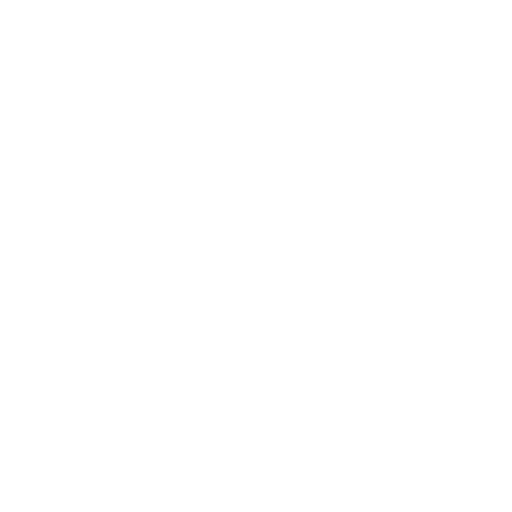

In [86]:
laplace_image = (laplace_x + laplace_y)
laplace_actual_relu = Image.fromarray(laplace_image.astype('uint8'))
laplace_actual_relu

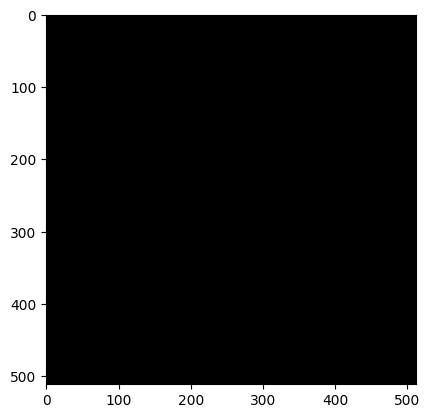

In [87]:
sobel_x = cv2.Sobel(laplace_image, cv2.CV_64F, 1, 0, ksize=3)

# Apply the Sobel filter in the y direction
sobel_y = cv2.Sobel(laplace_image, cv2.CV_64F, 0, 1, ksize=3)

# Compute the magnitude of the gradient
laplace_relu = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
plt.imshow(laplace_relu, cmap = "gray")

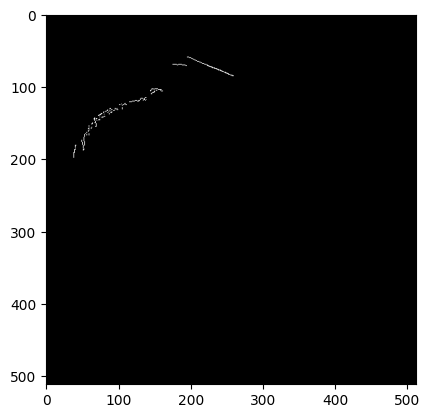

In [88]:
relu_img_gradient = cv2.Canny(y_image_values.astype('uint8'),50,150)
plt.imshow(relu_img_gradient, cmap = "gray")

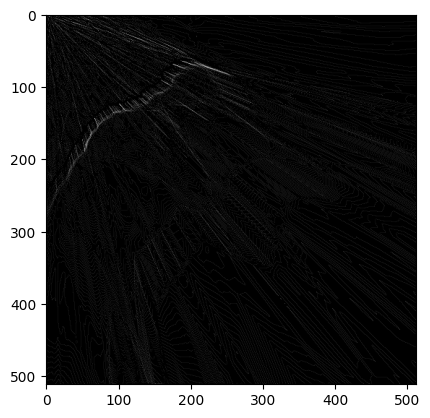

In [89]:
relu_img_laplacian = cv2.Laplacian(y_image_values.astype('uint8'),50,150)
plt.imshow(relu_img_laplacian, cmap = "gray")

In [90]:
siren_model = siren_mlp(256,5, 30).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(siren_model.parameters(), lr=0.0001)

In [91]:
siren_psnr = []

In [92]:
X.shape

(262144, 2)

In [93]:
num_epochs = 15000
for e in tqdm(range(num_epochs)):
  y_pred_train = siren_model(torch.from_numpy(X.astype('float32')).to(device)).squeeze()
  loss = criterion(y_pred_train, torch.from_numpy(y.astype('float32')).to(device)) # loss is a tensor which stores the current value of train loss
  siren_psnr.append(20 * np.log10(1.0 / np.sqrt(loss.item())))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 100 == 0:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss
  if e == num_epochs-1:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss

  0%|          | 3/15000 [00:00<31:37,  7.90it/s]

Epoch [0/15000], Loss: 0.3344


  1%|          | 101/15000 [00:14<42:08,  5.89it/s]

Epoch [100/15000], Loss: 0.3218


  1%|▏         | 201/15000 [00:28<41:47,  5.90it/s]

Epoch [200/15000], Loss: 0.2822


  2%|▏         | 301/15000 [00:43<42:14,  5.80it/s]

Epoch [300/15000], Loss: 0.2598


  3%|▎         | 401/15000 [00:57<42:54,  5.67it/s]

Epoch [400/15000], Loss: 0.2510


  3%|▎         | 503/15000 [01:12<34:10,  7.07it/s]

Epoch [500/15000], Loss: 0.2257


  4%|▍         | 601/15000 [01:27<43:02,  5.57it/s]

Epoch [600/15000], Loss: 0.1815


  5%|▍         | 701/15000 [01:42<42:56,  5.55it/s]

Epoch [700/15000], Loss: 0.1264


  5%|▌         | 801/15000 [01:57<42:54,  5.51it/s]

Epoch [800/15000], Loss: 0.1112


  6%|▌         | 901/15000 [02:12<42:46,  5.49it/s]

Epoch [900/15000], Loss: 0.1022


  7%|▋         | 1001/15000 [02:28<42:37,  5.47it/s]

Epoch [1000/15000], Loss: 0.0941


  7%|▋         | 1101/15000 [02:43<42:22,  5.47it/s]

Epoch [1100/15000], Loss: 0.0810


  8%|▊         | 1201/15000 [02:58<42:04,  5.47it/s]

Epoch [1200/15000], Loss: 0.0627


  9%|▊         | 1301/15000 [03:14<41:48,  5.46it/s]

Epoch [1300/15000], Loss: 0.0534


  9%|▉         | 1401/15000 [03:29<41:37,  5.45it/s]

Epoch [1400/15000], Loss: 0.0461


 10%|█         | 1501/15000 [03:45<41:29,  5.42it/s]

Epoch [1500/15000], Loss: 0.0405


 11%|█         | 1601/15000 [04:00<41:15,  5.41it/s]

Epoch [1600/15000], Loss: 0.0359


 11%|█▏        | 1701/15000 [04:15<40:49,  5.43it/s]

Epoch [1700/15000], Loss: 0.0315


 12%|█▏        | 1801/15000 [04:31<40:42,  5.40it/s]

Epoch [1800/15000], Loss: 0.0274


 13%|█▎        | 1901/15000 [04:46<40:22,  5.41it/s]

Epoch [1900/15000], Loss: 0.0235


 13%|█▎        | 2001/15000 [05:02<40:03,  5.41it/s]

Epoch [2000/15000], Loss: 0.0201


 14%|█▍        | 2101/15000 [05:17<39:46,  5.41it/s]

Epoch [2100/15000], Loss: 0.0173


 15%|█▍        | 2201/15000 [05:33<39:26,  5.41it/s]

Epoch [2200/15000], Loss: 0.0150


 15%|█▌        | 2301/15000 [05:49<39:17,  5.39it/s]

Epoch [2300/15000], Loss: 0.0131


 16%|█▌        | 2401/15000 [06:04<38:52,  5.40it/s]

Epoch [2400/15000], Loss: 0.0115


 17%|█▋        | 2501/15000 [06:20<38:40,  5.39it/s]

Epoch [2500/15000], Loss: 0.0103


 17%|█▋        | 2601/15000 [06:35<38:29,  5.37it/s]

Epoch [2600/15000], Loss: 0.0093


 18%|█▊        | 2701/15000 [06:51<37:59,  5.39it/s]

Epoch [2700/15000], Loss: 0.0084


 19%|█▊        | 2801/15000 [07:06<37:43,  5.39it/s]

Epoch [2800/15000], Loss: 0.0077


 19%|█▉        | 2901/15000 [07:22<37:32,  5.37it/s]

Epoch [2900/15000], Loss: 0.0071


 20%|██        | 3001/15000 [07:38<37:10,  5.38it/s]

Epoch [3000/15000], Loss: 0.0066


 21%|██        | 3101/15000 [07:53<36:49,  5.38it/s]

Epoch [3100/15000], Loss: 0.0061


 21%|██▏       | 3201/15000 [08:09<36:43,  5.35it/s]

Epoch [3200/15000], Loss: 0.0058


 22%|██▏       | 3301/15000 [08:24<36:15,  5.38it/s]

Epoch [3300/15000], Loss: 0.0054


 23%|██▎       | 3401/15000 [08:40<36:00,  5.37it/s]

Epoch [3400/15000], Loss: 0.0051


 23%|██▎       | 3501/15000 [08:56<35:43,  5.36it/s]

Epoch [3500/15000], Loss: 0.0049


 24%|██▍       | 3601/15000 [09:11<35:21,  5.37it/s]

Epoch [3600/15000], Loss: 0.0047


 25%|██▍       | 3701/15000 [09:27<35:08,  5.36it/s]

Epoch [3700/15000], Loss: 0.0045


 25%|██▌       | 3801/15000 [09:42<34:38,  5.39it/s]

Epoch [3800/15000], Loss: 0.0043


 26%|██▌       | 3901/15000 [09:58<34:24,  5.38it/s]

Epoch [3900/15000], Loss: 0.0041


 27%|██▋       | 4001/15000 [10:13<34:04,  5.38it/s]

Epoch [4000/15000], Loss: 0.0040


 27%|██▋       | 4101/15000 [10:29<33:43,  5.39it/s]

Epoch [4100/15000], Loss: 0.0039


 28%|██▊       | 4201/15000 [10:45<33:25,  5.38it/s]

Epoch [4200/15000], Loss: 0.0037


 29%|██▊       | 4301/15000 [11:00<33:04,  5.39it/s]

Epoch [4300/15000], Loss: 0.0036


 29%|██▉       | 4401/15000 [11:16<32:44,  5.40it/s]

Epoch [4400/15000], Loss: 0.0035


 30%|███       | 4501/15000 [11:31<32:24,  5.40it/s]

Epoch [4500/15000], Loss: 0.0034


 31%|███       | 4601/15000 [11:47<32:18,  5.36it/s]

Epoch [4600/15000], Loss: 0.0033


 31%|███▏      | 4701/15000 [12:02<31:50,  5.39it/s]

Epoch [4700/15000], Loss: 0.0033


 32%|███▏      | 4801/15000 [12:18<31:33,  5.38it/s]

Epoch [4800/15000], Loss: 0.0032


 33%|███▎      | 4901/15000 [12:33<31:12,  5.39it/s]

Epoch [4900/15000], Loss: 0.0031


 33%|███▎      | 5001/15000 [12:49<31:00,  5.37it/s]

Epoch [5000/15000], Loss: 0.0030


 34%|███▍      | 5101/15000 [13:05<30:35,  5.39it/s]

Epoch [5100/15000], Loss: 0.0030


 35%|███▍      | 5201/15000 [13:20<30:19,  5.39it/s]

Epoch [5200/15000], Loss: 0.0029


 35%|███▌      | 5301/15000 [13:36<29:59,  5.39it/s]

Epoch [5300/15000], Loss: 0.0028


 36%|███▌      | 5401/15000 [13:51<29:59,  5.33it/s]

Epoch [5400/15000], Loss: 0.0028


 37%|███▋      | 5501/15000 [14:07<29:38,  5.34it/s]

Epoch [5500/15000], Loss: 0.0027


 37%|███▋      | 5601/15000 [14:23<29:18,  5.34it/s]

Epoch [5600/15000], Loss: 0.0027


 38%|███▊      | 5701/15000 [14:38<29:10,  5.31it/s]

Epoch [5700/15000], Loss: 0.0026


 39%|███▊      | 5801/15000 [14:54<29:00,  5.29it/s]

Epoch [5800/15000], Loss: 0.0026


 39%|███▉      | 5901/15000 [15:10<29:19,  5.17it/s]

Epoch [5900/15000], Loss: 0.0026


 40%|████      | 6001/15000 [15:26<28:49,  5.20it/s]

Epoch [6000/15000], Loss: 0.0025


 41%|████      | 6101/15000 [15:42<28:18,  5.24it/s]

Epoch [6100/15000], Loss: 0.0025


 41%|████▏     | 6201/15000 [15:58<27:49,  5.27it/s]

Epoch [6200/15000], Loss: 0.0024


 42%|████▏     | 6301/15000 [16:14<27:27,  5.28it/s]

Epoch [6300/15000], Loss: 0.0024


 43%|████▎     | 6401/15000 [16:30<27:07,  5.29it/s]

Epoch [6400/15000], Loss: 0.0024


 43%|████▎     | 6501/15000 [16:45<26:54,  5.26it/s]

Epoch [6500/15000], Loss: 0.0023


 44%|████▍     | 6601/15000 [17:01<26:24,  5.30it/s]

Epoch [6600/15000], Loss: 0.0023


 45%|████▍     | 6701/15000 [17:17<26:04,  5.30it/s]

Epoch [6700/15000], Loss: 0.0022


 45%|████▌     | 6801/15000 [17:33<25:44,  5.31it/s]

Epoch [6800/15000], Loss: 0.0022


 46%|████▌     | 6901/15000 [17:49<25:29,  5.30it/s]

Epoch [6900/15000], Loss: 0.0022


 47%|████▋     | 7001/15000 [18:05<25:08,  5.30it/s]

Epoch [7000/15000], Loss: 0.0021


 47%|████▋     | 7101/15000 [18:20<24:43,  5.32it/s]

Epoch [7100/15000], Loss: 0.0021


 48%|████▊     | 7201/15000 [18:36<24:33,  5.29it/s]

Epoch [7200/15000], Loss: 0.0021


 49%|████▊     | 7301/15000 [18:52<24:18,  5.28it/s]

Epoch [7300/15000], Loss: 0.0021


 49%|████▉     | 7401/15000 [19:08<23:57,  5.29it/s]

Epoch [7400/15000], Loss: 0.0020


 50%|█████     | 7501/15000 [19:24<23:43,  5.27it/s]

Epoch [7500/15000], Loss: 0.0020


 51%|█████     | 7601/15000 [19:40<23:17,  5.29it/s]

Epoch [7600/15000], Loss: 0.0019


 51%|█████▏    | 7701/15000 [19:55<23:02,  5.28it/s]

Epoch [7700/15000], Loss: 0.0019


 52%|█████▏    | 7801/15000 [20:11<22:43,  5.28it/s]

Epoch [7800/15000], Loss: 0.0019


 53%|█████▎    | 7901/15000 [20:27<22:25,  5.28it/s]

Epoch [7900/15000], Loss: 0.0019


 53%|█████▎    | 8001/15000 [20:43<22:06,  5.28it/s]

Epoch [8000/15000], Loss: 0.0019


 54%|█████▍    | 8101/15000 [20:59<21:46,  5.28it/s]

Epoch [8100/15000], Loss: 0.0018


 55%|█████▍    | 8201/15000 [21:15<21:30,  5.27it/s]

Epoch [8200/15000], Loss: 0.0018


 55%|█████▌    | 8301/15000 [21:30<21:05,  5.29it/s]

Epoch [8300/15000], Loss: 0.0018


 56%|█████▌    | 8401/15000 [21:46<20:44,  5.30it/s]

Epoch [8400/15000], Loss: 0.0017


 57%|█████▋    | 8501/15000 [22:02<20:22,  5.31it/s]

Epoch [8500/15000], Loss: 0.0017


 57%|█████▋    | 8601/15000 [22:18<20:08,  5.29it/s]

Epoch [8600/15000], Loss: 0.0017


 58%|█████▊    | 8701/15000 [22:34<19:52,  5.28it/s]

Epoch [8700/15000], Loss: 0.0017


 59%|█████▊    | 8801/15000 [22:50<19:35,  5.27it/s]

Epoch [8800/15000], Loss: 0.0017


 59%|█████▉    | 8901/15000 [23:05<19:12,  5.29it/s]

Epoch [8900/15000], Loss: 0.0016


 60%|██████    | 9001/15000 [23:21<18:58,  5.27it/s]

Epoch [9000/15000], Loss: 0.0016


 61%|██████    | 9101/15000 [23:37<18:37,  5.28it/s]

Epoch [9100/15000], Loss: 0.0016


 61%|██████▏   | 9201/15000 [23:53<18:23,  5.26it/s]

Epoch [9200/15000], Loss: 0.0016


 62%|██████▏   | 9301/15000 [24:09<18:08,  5.24it/s]

Epoch [9300/15000], Loss: 0.0016


 63%|██████▎   | 9401/15000 [24:25<17:51,  5.22it/s]

Epoch [9400/15000], Loss: 0.0015


 63%|██████▎   | 9501/15000 [24:41<17:41,  5.18it/s]

Epoch [9500/15000], Loss: 0.0015


 64%|██████▍   | 9601/15000 [24:57<17:17,  5.21it/s]

Epoch [9600/15000], Loss: 0.0015


 65%|██████▍   | 9701/15000 [25:13<16:48,  5.25it/s]

Epoch [9700/15000], Loss: 0.0015


 65%|██████▌   | 9801/15000 [25:29<16:35,  5.22it/s]

Epoch [9800/15000], Loss: 0.0015


 66%|██████▌   | 9901/15000 [25:45<16:11,  5.25it/s]

Epoch [9900/15000], Loss: 0.0015


 67%|██████▋   | 10001/15000 [26:01<15:50,  5.26it/s]

Epoch [10000/15000], Loss: 0.0014


 67%|██████▋   | 10101/15000 [26:17<15:42,  5.20it/s]

Epoch [10100/15000], Loss: 0.0014


 68%|██████▊   | 10201/15000 [26:33<15:15,  5.24it/s]

Epoch [10200/15000], Loss: 0.0014


 69%|██████▊   | 10301/15000 [26:49<14:53,  5.26it/s]

Epoch [10300/15000], Loss: 0.0014


 69%|██████▉   | 10401/15000 [27:05<14:38,  5.23it/s]

Epoch [10400/15000], Loss: 0.0014


 70%|███████   | 10501/15000 [27:21<14:27,  5.18it/s]

Epoch [10500/15000], Loss: 0.0014


 71%|███████   | 10601/15000 [27:37<14:00,  5.23it/s]

Epoch [10600/15000], Loss: 0.0014


 71%|███████▏  | 10701/15000 [27:53<13:37,  5.26it/s]

Epoch [10700/15000], Loss: 0.0013


 72%|███████▏  | 10801/15000 [28:09<13:23,  5.22it/s]

Epoch [10800/15000], Loss: 0.0013


 73%|███████▎  | 10901/15000 [28:25<13:03,  5.23it/s]

Epoch [10900/15000], Loss: 0.0013


 73%|███████▎  | 11001/15000 [28:40<12:37,  5.28it/s]

Epoch [11000/15000], Loss: 0.0013


 74%|███████▍  | 11101/15000 [28:56<12:17,  5.29it/s]

Epoch [11100/15000], Loss: 0.0013


 75%|███████▍  | 11201/15000 [29:12<12:00,  5.27it/s]

Epoch [11200/15000], Loss: 0.0013


 75%|███████▌  | 11301/15000 [29:28<11:43,  5.26it/s]

Epoch [11300/15000], Loss: 0.0013


 76%|███████▌  | 11401/15000 [29:44<11:22,  5.28it/s]

Epoch [11400/15000], Loss: 0.0012


 77%|███████▋  | 11501/15000 [30:00<11:01,  5.29it/s]

Epoch [11500/15000], Loss: 0.0012


 77%|███████▋  | 11601/15000 [30:16<10:46,  5.26it/s]

Epoch [11600/15000], Loss: 0.0012


 78%|███████▊  | 11701/15000 [30:32<10:25,  5.27it/s]

Epoch [11700/15000], Loss: 0.0012


 79%|███████▊  | 11801/15000 [30:48<10:03,  5.30it/s]

Epoch [11800/15000], Loss: 0.0012


 79%|███████▉  | 11901/15000 [31:04<09:46,  5.29it/s]

Epoch [11900/15000], Loss: 0.0012


 80%|████████  | 12001/15000 [31:19<09:28,  5.27it/s]

Epoch [12000/15000], Loss: 0.0012


 81%|████████  | 12101/15000 [31:35<09:10,  5.27it/s]

Epoch [12100/15000], Loss: 0.0012


 81%|████████▏ | 12201/15000 [31:51<08:51,  5.26it/s]

Epoch [12200/15000], Loss: 0.0012


 82%|████████▏ | 12301/15000 [32:07<08:26,  5.33it/s]

Epoch [12300/15000], Loss: 0.0011


 83%|████████▎ | 12401/15000 [32:23<08:15,  5.25it/s]

Epoch [12400/15000], Loss: 0.0011


 83%|████████▎ | 12501/15000 [32:39<07:53,  5.27it/s]

Epoch [12500/15000], Loss: 0.0012


 84%|████████▍ | 12601/15000 [32:55<07:32,  5.30it/s]

Epoch [12600/15000], Loss: 0.0011


 85%|████████▍ | 12701/15000 [33:10<07:14,  5.30it/s]

Epoch [12700/15000], Loss: 0.0011


 85%|████████▌ | 12801/15000 [33:26<06:55,  5.29it/s]

Epoch [12800/15000], Loss: 0.0011


 86%|████████▌ | 12901/15000 [33:42<06:35,  5.31it/s]

Epoch [12900/15000], Loss: 0.0011


 87%|████████▋ | 13001/15000 [33:58<06:16,  5.32it/s]

Epoch [13000/15000], Loss: 0.0011


 87%|████████▋ | 13101/15000 [34:14<05:59,  5.28it/s]

Epoch [13100/15000], Loss: 0.0011


 88%|████████▊ | 13201/15000 [34:30<05:39,  5.29it/s]

Epoch [13200/15000], Loss: 0.0010


 89%|████████▊ | 13301/15000 [34:45<05:22,  5.27it/s]

Epoch [13300/15000], Loss: 0.0010


 89%|████████▉ | 13401/15000 [35:01<05:01,  5.30it/s]

Epoch [13400/15000], Loss: 0.0010


 90%|█████████ | 13501/15000 [35:17<04:44,  5.27it/s]

Epoch [13500/15000], Loss: 0.0010


 91%|█████████ | 13601/15000 [35:33<04:25,  5.28it/s]

Epoch [13600/15000], Loss: 0.0010


 91%|█████████▏| 13701/15000 [35:49<04:06,  5.27it/s]

Epoch [13700/15000], Loss: 0.0010


 92%|█████████▏| 13801/15000 [36:05<03:47,  5.26it/s]

Epoch [13800/15000], Loss: 0.0010


 93%|█████████▎| 13901/15000 [36:20<03:28,  5.28it/s]

Epoch [13900/15000], Loss: 0.0010


 93%|█████████▎| 14001/15000 [36:36<03:09,  5.28it/s]

Epoch [14000/15000], Loss: 0.0010


 94%|█████████▍| 14101/15000 [36:52<02:49,  5.30it/s]

Epoch [14100/15000], Loss: 0.0010


 95%|█████████▍| 14201/15000 [37:08<02:31,  5.26it/s]

Epoch [14200/15000], Loss: 0.0010


 95%|█████████▌| 14301/15000 [37:24<02:12,  5.29it/s]

Epoch [14300/15000], Loss: 0.0009


 96%|█████████▌| 14401/15000 [37:40<01:53,  5.30it/s]

Epoch [14400/15000], Loss: 0.0009


 97%|█████████▋| 14501/15000 [37:56<01:34,  5.26it/s]

Epoch [14500/15000], Loss: 0.0009


 97%|█████████▋| 14601/15000 [38:11<01:15,  5.28it/s]

Epoch [14600/15000], Loss: 0.0009


 98%|█████████▊| 14701/15000 [38:27<00:56,  5.27it/s]

Epoch [14700/15000], Loss: 0.0009


 99%|█████████▊| 14801/15000 [38:43<00:37,  5.29it/s]

Epoch [14800/15000], Loss: 0.0009


 99%|█████████▉| 14901/15000 [38:59<00:18,  5.28it/s]

Epoch [14900/15000], Loss: 0.0009


100%|██████████| 15000/15000 [39:15<00:00,  6.37it/s]

Epoch [14999/15000], Loss: 0.0009


In [94]:
len(siren_psnr)

15000

In [95]:
y_preds = siren_model(torch.from_numpy(X.astype('float32')).to(device))

In [97]:
y_image_values = (y_preds.cpu().detach().numpy().reshape(512,512)*127.5)+127.5
y_image_values

array([[206.95639 , 197.57608 , 199.44858 , ..., 192.47083 , 190.77414 ,
        187.99207 ],
       [200.84995 , 196.99838 , 202.82413 , ..., 187.7858  , 190.68748 ,
        192.99336 ],
       [199.66731 , 202.57391 , 199.7965  , ..., 185.7875  , 190.23166 ,
        190.85184 ],
       ...,
       [ 25.655594,  24.593086,  24.768173, ..., 148.88162 , 120.99104 ,
        146.67398 ],
       [ 23.828033,  26.939743,  24.136482, ..., 157.97939 , 136.05469 ,
        171.57945 ],
       [ 25.43808 ,  26.92894 ,  27.675476, ..., 157.07695 , 150.76857 ,
        149.53664 ]], dtype=float32)

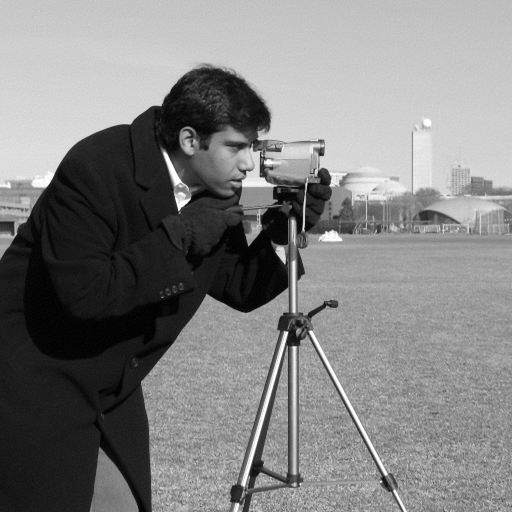

In [98]:
siren_img = Image.fromarray(y_image_values)
siren_img.show()

In [99]:
X_temp = torch.tensor(X.astype('float32'), requires_grad = True).to(device)
y_preds = siren_model(X_temp).to(device)

In [100]:
grad_ = torch.autograd.grad(y_preds, X_temp,grad_outputs = torch.ones_like(y_preds), create_graph=True)[0]

In [101]:
type(grad_), grad_.shape

(torch.Tensor, torch.Size([262144, 2]))

In [102]:
grad_array = grad_.cpu().detach().numpy()
grad_array

array([[ 6.54949620e-02,  3.98090541e-01],
       [ 3.82330865e-01,  6.59149289e-01],
       [ 7.23360032e-02,  5.40081004e-04],
       ...,
       [-3.20363082e-02,  4.69275676e-02],
       [ 5.92331775e-02, -1.12153694e-01],
       [-1.96000822e-02,  1.05515599e-01]], dtype=float32)

In [103]:
grad_array.shape

(262144, 2)

In [104]:
grad_x = grad_array[:, 0].reshape(-1, 1)
grad_y = grad_array[:, 1].reshape(-1, 1)

In [105]:
grad_x = grad_x.reshape(512,512)
grad_y = grad_y.reshape(512,512)
grad_x = (grad_x*127.5) + 127.5
grad_y = (grad_y*127.5) + 127.5

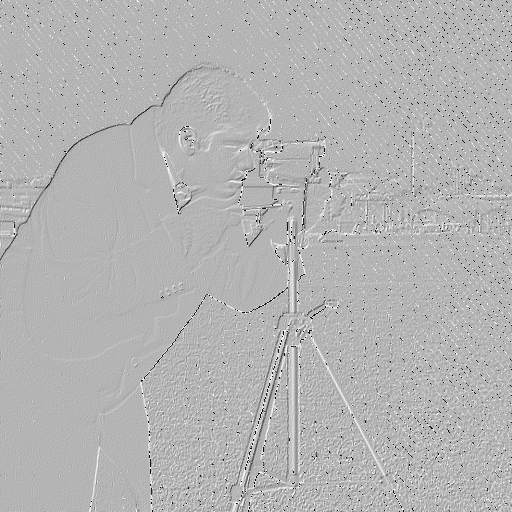

In [118]:
gradient_image = np.sqrt(grad_x**2 + grad_y**2)
gradient_actual_siren = Image.fromarray(gradient_image.astype('uint8'))
gradient_actual_siren

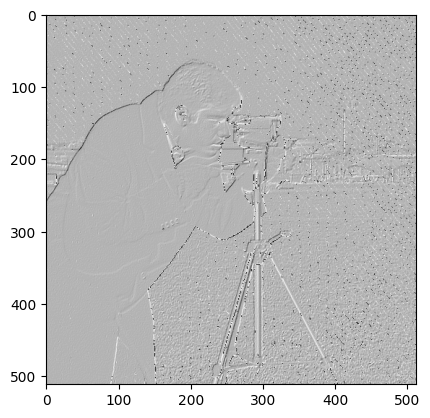

In [132]:
plt.imshow(gradient_actual_siren, cmap = "gray")

In [139]:
pil_grad_siren = Image.fromarray(gradient_image)
pil_grad_siren = pil_grad_siren.convert("L")

In [136]:
from PIL import Image, ImageFilter

In [140]:
gradient_siren = pil_grad_siren.filter(ImageFilter.FIND_EDGES)

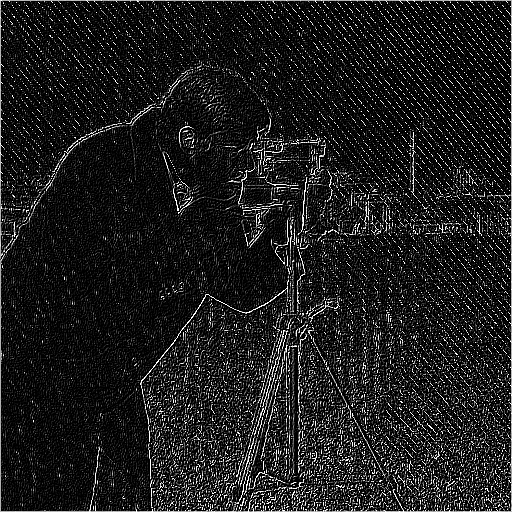

In [141]:
gradient_siren

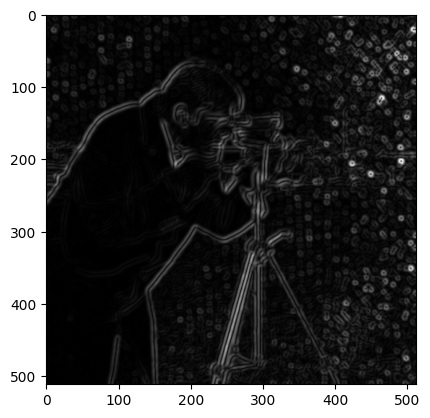

In [131]:
"""sobel_x = cv2.Sobel(gradient_image, cv2.CV_64F, 1, 0, ksize=21)

# Apply the Sobel filter in the y direction
sobel_y = cv2.Sobel(gradient_image, cv2.CV_64F, 0, 1, ksize=21)

# Compute the magnitude of the gradient
gradient_siren = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
plt.imshow(gradient_siren, cmap = "gray")"""

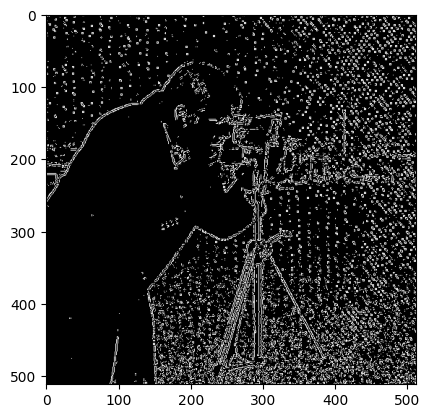

In [130]:
"""gradient_siren = cv2.Canny(gradient_image.astype('uint8'),150,150)
plt.imshow(gradient_siren, cmap = "gray")"""

In [142]:
laplace = torch.autograd.grad(torch.sum(grad_), X_temp)[0]

In [143]:
laplace

tensor([[-6.8264e-01, -3.9631e-01],
        [ 7.9938e-01, -4.5346e+00],
        [-1.1275e-01, -6.6983e-02],
        ...,
        [-3.7916e-03, -2.4180e-01],
        [-8.1164e-02,  6.6609e-02],
        [-1.9910e-01,  9.3562e-02]], device='cuda:0')

In [144]:
laplace.shape

torch.Size([262144, 2])

In [145]:
laplace_array = laplace.cpu().detach().numpy()
laplace_array

array([[-6.8264461e-01, -3.9630544e-01],
       [ 7.9937679e-01, -4.5346432e+00],
       [-1.1274793e-01, -6.6983089e-02],
       ...,
       [-3.7916270e-03, -2.4179517e-01],
       [-8.1164151e-02,  6.6609442e-02],
       [-1.9910316e-01,  9.3562238e-02]], dtype=float32)

In [146]:
laplace_array.shape

(262144, 2)

In [147]:
laplace_x = laplace_array[:, 0].reshape(-1, 1)
laplace_y = laplace_array[:, 1].reshape(-1, 1)

In [148]:
laplace_x = laplace_x.reshape(512,512)
laplace_y = laplace_y.reshape(512,512)
laplace_x = (laplace_x*127.5) + 127.5
laplace_y = (laplace_y*127.5) + 127.5

In [149]:
laplace_image

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]], dtype=float32)

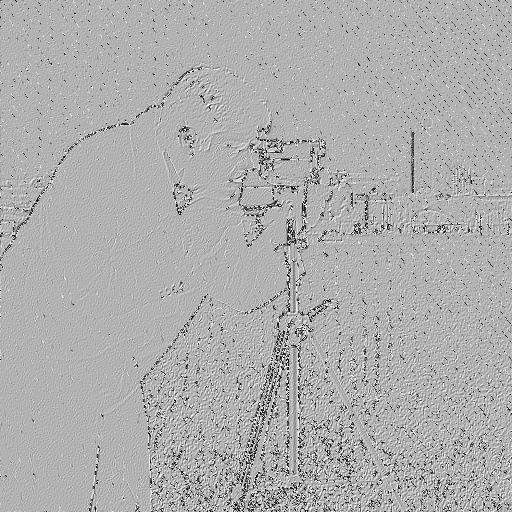

In [150]:
laplace_image = 0.7*(laplace_x + laplace_y)
laplace_actual_siren = Image.fromarray(laplace_image.astype('uint8'))
laplace_actual_siren

In [152]:
pil_laplace_siren = Image.fromarray(laplace_image)
pil_laplace_siren = pil_laplace_siren.convert("L")

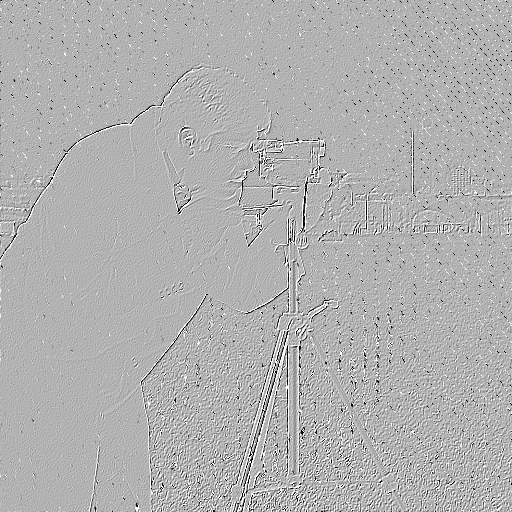

In [158]:
pil_laplace_siren

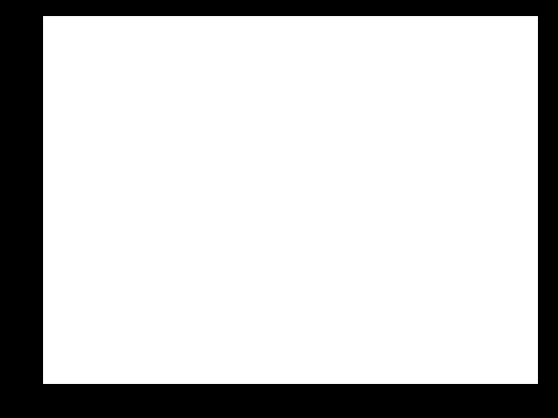

In [165]:
fig, ax = plt.subplots(facecolor='black')

In [167]:
im = ax.imshow(pil_grad_siren, cmap = 'binary')
im.set_edgecolor('white')

AttributeError: ignored

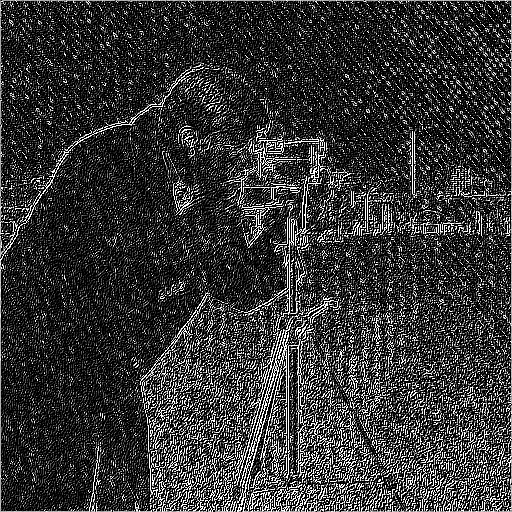

In [168]:
laplace_siren = pil_laplace_siren.filter(ImageFilter.FIND_EDGES)
laplace_siren

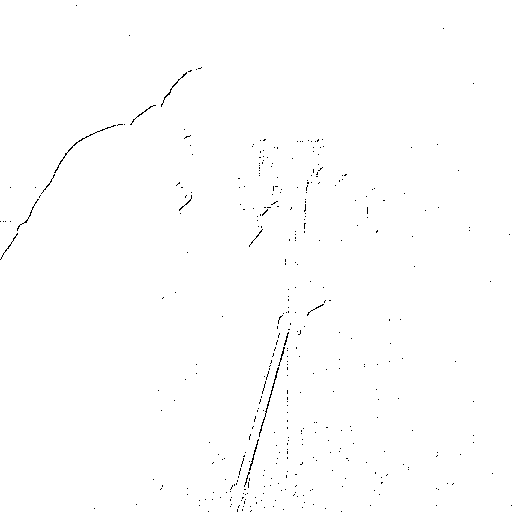

In [160]:
"""pill_grad_siren = pil_grad_siren.point(lambda x: 0 if x < 128 else 255, mode='1')
pill_grad_siren"""

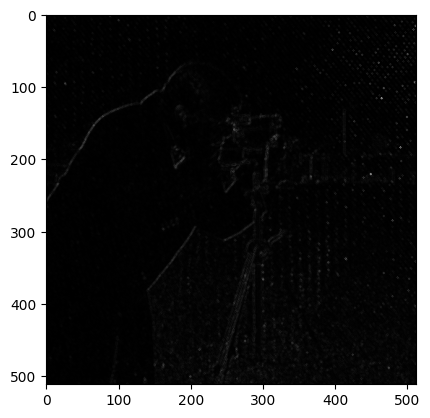

In [151]:
"""sobel_x = cv2.Sobel(laplace_image, cv2.CV_64F, 1, 0, ksize=1)

# Apply the Sobel filter in the y direction
sobel_y = cv2.Sobel(laplace_image, cv2.CV_64F, 0, 1, ksize=1)

# Compute the magnitude of the gradient
laplace_siren = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
plt.imshow(laplace_siren, cmap = "gray")"""

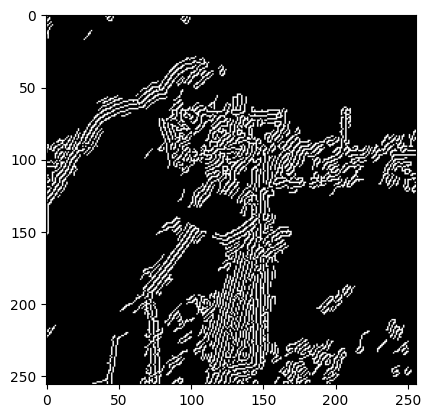

In [ ]:
"""siren_img_gradient = cv2.Canny(laplace_image.astype('uint8'),50,150)
plt.imshow(siren_img_gradient, cmap = "gray")"""

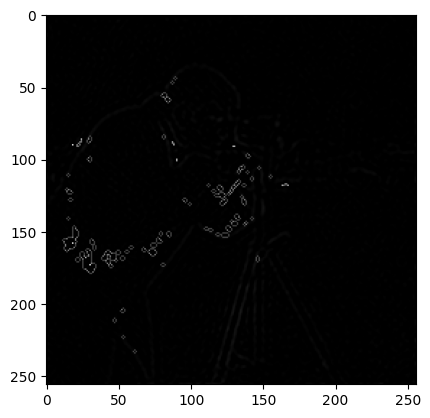

In [ ]:
siren_img_laplacian = cv2.Laplacian(y_image_values.astype('uint8'),50,150)
plt.imshow(siren_img_laplacian, cmap = "gray")

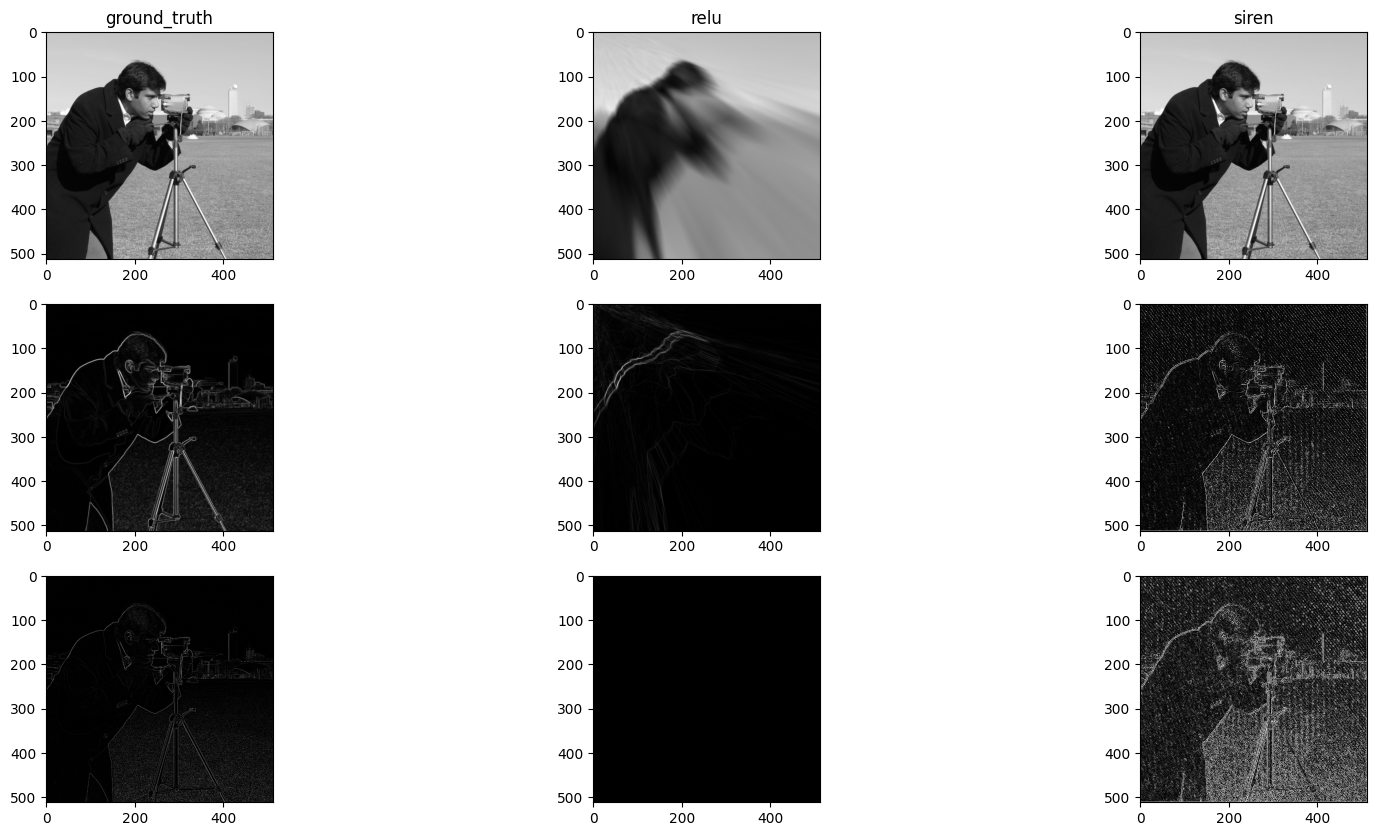

In [170]:
fig,ax = plt.subplots(3,3, figsize = (20,10))
ax[0,0].imshow(image_array, cmap = "gray")
ax[1,0].imshow(mag, cmap = "gray")
ax[2,0].imshow(img_laplacian,cmap = "gray")
ax[0,1].imshow(relu_img,cmap = "gray")
ax[1,1].imshow(grad_relu,cmap = "gray")
ax[2,1].imshow(laplace_relu,cmap = "gray")
ax[0,2].imshow(siren_img,cmap = "gray")
ax[1,2].imshow(gradient_siren, cmap = 'gray')
ax[2,2].imshow(laplace_siren, cmap = "gray")
ax[0,0].set(title = 'ground_truth')
ax[0,1].set(title = 'relu')
ax[0,2].set(title = 'siren')
plt.show()

In [ ]:
gradient_siren

array([[  0.        ,  53.88964844,  42.92962646, ...,   8.11456299,
         24.07327271,   0.        ],
       [  1.93447876,  73.24142761,  49.21481219, ...,  20.36964468,
         20.47626699,   3.62506104],
       [ 68.27593994, 105.92250913,  45.2828613 , ...,  13.45067995,
         20.45025439,  19.62374878],
       ...,
       [ 29.29849243,  21.86544689,   6.93682911, ...,  12.30016871,
         10.72612586,  14.96844482],
       [ 36.52456665,  29.42473434,  23.96041171, ...,  11.05378291,
          6.16011252,   2.57751465],
       [  0.        ,  14.72579956,   1.73321533, ...,   4.78436279,
         10.93673706,   0.        ]])

In [ ]:
laplace_siren

array([[ 0.        , 23.06547546,  6.24958801, ...,  4.97402954,
         1.70144653,  0.        ],
       [43.93873596, 23.89447566, 11.67022256, ..., 13.30208318,
        15.21891818,  9.11181641],
       [32.84587097, 21.05112614, 27.89993482, ...,  6.60679799,
         4.04857695,  2.9259491 ],
       ...,
       [ 2.22979736, 12.14950832,  6.15351772, ...,  7.09728362,
         6.14091152,  0.39274597],
       [11.27947998,  5.65714783,  8.39254515, ...,  4.09510536,
         0.62947694,  6.04814148],
       [ 0.        ,  7.51219177,  7.96183777, ...,  6.6729126 ,
         2.94229126,  0.        ]])

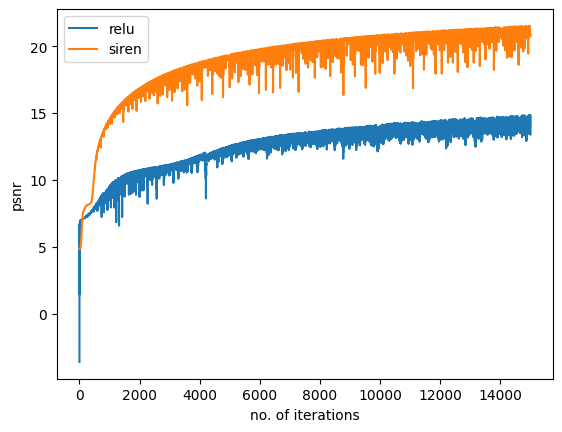

In [ ]:
plt.xlabel('no. of iterations')
plt.ylabel('psnr')
plt.plot(range(15000), relu_psnr, label = 'relu')
plt.plot(range(15000), siren_psnr, label = 'siren')
plt.legend()
plt.show()